# Google trends data exploration

In [17]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from graphviz import Digraph
from collections import deque

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
pytrends = TrendReq(hl='en-US', tz=360)

### Setup a payload for 'Gas prices' in the US 

In [3]:
keyword = "Gas prices"
kw_list = [keyword]
pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='US', gprop='')

In [4]:
# Get the gasoline interest dataframe.
interest_df = pytrends.interest_over_time()
interest_df.head()

# TODO: List some major economic events in the U.S.
# Can even look at data by state - geo = 'US-WA' for example. can do a map visualization over time of state relative queries.

,Gas prices,isPartial
date,,
2004-01-01,5,False
2004-02-01,6,False
2004-03-01,11,False
2004-04-01,11,False
2004-05-01,32,False


#### What do the numbers represent?
From google trends: "Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term."

### Check for null entries

In [6]:
has_null = any(interest_df[keyword].isnull())
if has_null:
    print("Null entries found... removing null entries")
    interest_df = interest_df.dropna()
    has_null = any(interest_df['Gas prices'].isnull())
    
assert not has_null

### Check that there is consistent time granularity between rows

In [7]:
for i in range(interest_df.shape[0] - 1):
    entry_time_difference = interest_df.index[i + 1] - interest_df.index[i]
    x = list(entry_time_difference.components)
    assert sum(x) == max(x)

# A sample difference in time between rows.
print("Time granularity is approximately:", entry_time_difference)

Time granularity is approximately: 30 days 00:00:00


### Describe data

In [8]:
interest_df.describe()

,Gas prices
count,185.000000
mean,13.632432
std,11.255193
min,5.000000
25%,8.000000
50%,10.000000
75%,14.000000
max,100.000000


### Trend visualization for keywords

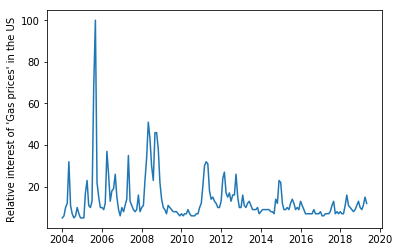

In [9]:
for k_word in interest_df.columns:
    if k_word == 'isPartial':
        continue
        
    plt.plot(interest_df.index, interest_df[k_word])
    plt.ylabel("Relative interest of \'{}\' in the US".format(k_word))
    plt.show()

## Sample ARIMA model fitting on data

In [10]:
# TODO: Check conditions for ARIMA modelling

### Autocorrelation plot

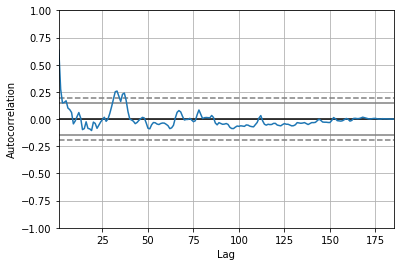

In [11]:
autocorrelation_plot(interest_df[keyword])

In [12]:

model = ARIMA(interest_df[keyword], order=(7,1,0), dates=interest_df.index)
model_fit = model.fit()

interest_df[keyword].shape
#print(model_fit.summary())

/Users/arvinds/anaconda3/envs/future_gas/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/arvinds/anaconda3/envs/future_gas/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/arvinds/anaconda3/envs/future_gas/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


(185,)

### Fitted ARIMA model

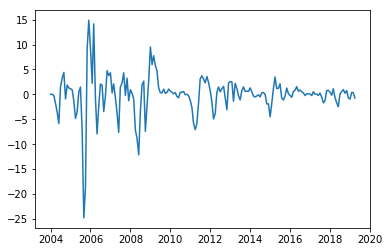

In [30]:
plt.plot(interest_df.index[:-1], model_fit.fittedvalues)

### Residuals of model vs. real data

                0
count  184.000000
mean     0.043106
std      8.667875
min    -51.209124
25%     -2.318697
50%     -0.515718
75%      1.621157
max     52.536320


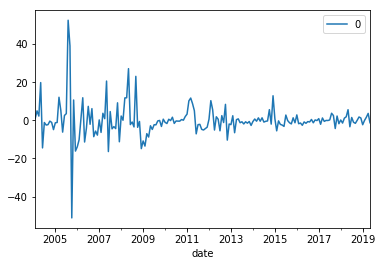

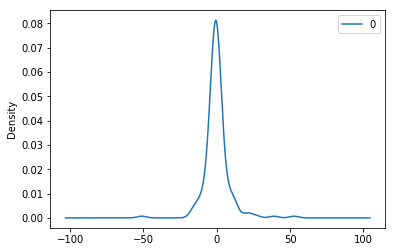

In [31]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

## Using related queries as feedback to get more results

In [18]:
def get_related_for_keyword(kw):
    kw_list = [kw]
    pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='US', gprop='')
    interest_df = pytrends.interest_over_time()
    return pytrends.related_queries()

In [30]:
# Modify these to grow the size of the tree and to choose a different starting keyword
start_kw = 'Gas prices'
num_iters = 5


graph_dict = {}
q = deque()
q.append(start_kw)

for i in range(num_iters):
    # get the next keyword
    kw = q.popleft()
    print("Finding related terms to {}...".format(kw))
    
    # Get related keywords for given keyword
    related = get_related_for_keyword(kw)

    # Get the top 5 related keywords
    top_5 = list(related[kw]['top'][:5]['query'].values)
    
    # Add to graph data dict
    if kw not in graph_dict:
        graph_dict[kw] = []
    graph_dict[kw] = top_5
    
    q.extend(top_5)
print("Done")

Finding related terms to Gas prices...
Finding related terms to gas near me prices...
Finding related terms to gas near me...
Finding related terms to gas price...
Finding related terms to natural gas...
Done


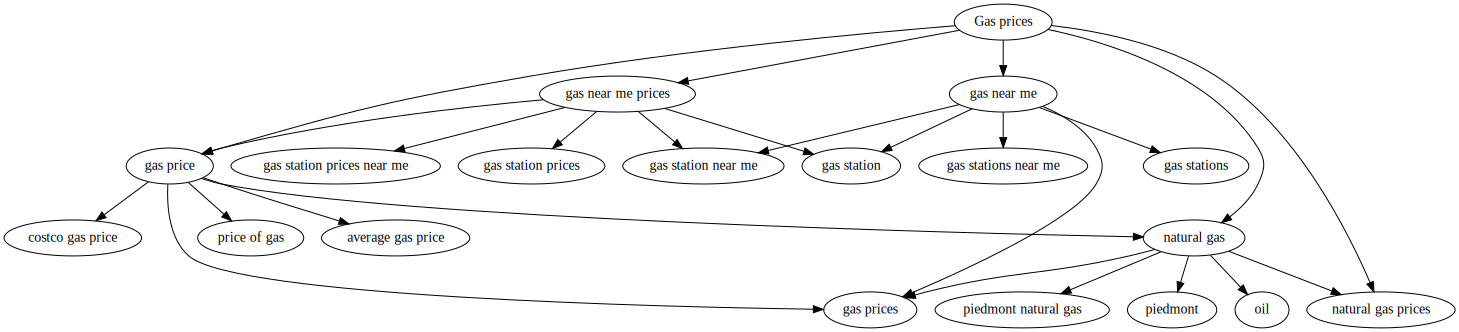

In [31]:
dot = Digraph()

for kw in graph_dict:
    dot.node(kw, kw)
    for child in graph_dict[kw]:
        dot.node(child, child)
        dot.edge(kw, child)
#dot.render('test', view=True, cleanup=True)
dot